# Machine Learning

Here we will train a neural network.


We begin with some initial classes and functions to load data

In [1]:
import random
import numpy as np
import torch
import sys
import pandas as pd

class Dataset(torch.utils.data.Dataset):
# optional parameters allow target data to be shifted and scaled
    def __init__(self, target, data):
        self.label = target.astype(np.float32)
# assumes that data is prepared in correct shape beforehand
        self.input = data
    def __len__(self):
        return self.label.shape[0]
    def __getitem__(self, index):
        return self.input[index].astype(np.float32), self.label[index]
    
def randomsplitdata(target_input_fn,training_fraction,maxrows=99999999):
    f=open(target_input_fn)
    lsplit=f.readline().split()
    f.close()
        
    dft=pd.read_csv(target_input_fn,sep=' ',header=None,usecols=range(0,3),nrows=maxrows)
    targetdata=dft.to_numpy()

    dfi=pd.read_csv(target_input_fn,sep=' ',header=None,usecols=range(4,len(lsplit)),nrows=maxrows)
    inputdata=np.reshape(dfi.to_numpy(),(len(dfi),1,-1))
    
    xlist=[*range(4,len(lsplit),3)]
    ylist=[*range(5,len(lsplit),3)]
    zlist=[*range(6,len(lsplit),3)]
    
    dfixyz=dfi[xlist+ylist+zlist]
    inpxyzdata=np.reshape(dfixyz.to_numpy(),(len(dfi),3,-1)) 
    
    print(len(targetdata))
    
    flag=np.zeros(len(targetdata),dtype=int)
    while np.average(flag)<training_fraction:
        flag[random.randint(0,len(targetdata)-1)]=1
    
    target_training=targetdata[np.nonzero(flag)].copy()
    target_validation=targetdata[np.nonzero(1-flag)].copy()
    input_training=inputdata[np.nonzero(flag)].copy()
    input_validation=inputdata[np.nonzero(1-flag)].copy()
    inputxyz_training=inpxyzdata[np.nonzero(flag)].copy()
    inputxyz_validation=inpxyzdata[np.nonzero(1-flag)].copy()
        
    return target_training,input_training,inputxyz_training, \
           target_validation,input_validation,inputxyz_validation

def get_loaders(target_input_fn,training_fraction,batch_size=128,maxrows=99999999):
    [ttarget,tinput,tinpxyz,vtarget,vinput,vinpxyz]=randomsplitdata(target_input_fn,training_fraction,maxrows) 
    
    train_set=Dataset(ttarget,tinput)
    validation_set=Dataset(vtarget,vinput)
    trainxyz_set=Dataset(ttarget,tinpxyz)
    valixyz_set=Dataset(vtarget,vinpxyz)
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=1)
    
    trainxyz_loader = torch.utils.data.DataLoader(trainxyz_set, batch_size=batch_size, shuffle=True)
    valixyz_loader = torch.utils.data.DataLoader(valixyz_set, batch_size=1)
    
    return train_loader,validation_loader,trainxyz_loader,valixyz_loader        

Now we setup some training functions.

In [2]:
import numpy as np

def train(m,loss_fn,opt,loader,xscale=1.0,yscale=1.0,zscale=1.0,klfactor=0.0):
    klloss=nn.KLDivLoss(reduction='batchmean')
    
    loss_sum = 0.0
    for input, label in loader:
        opt.zero_grad()
        
        output = m(input)              # this is where the model is evaluated
        
        loss =  loss_fn(output[:,0], label[:,0])*xscale  # model loss for x
        loss += loss_fn(output[:,1], label[:,1])*yscale  # model loss for y
        loss += loss_fn(output[:,2], label[:,2])*zscale  # model loss for z
        
        loss_sum += loss.item()        # accumulate MSE loss
            
        if (klfactor>0):
            loss=loss+klfactor*klloss(output[:,0],label[:,0])
            
        loss.backward()                # this calculates the back-propagated loss
        opt.step()                     # this carries out the gradient descent
    
    return loss_sum / len(loader)      # Note: KL loss is not included in reported loss

def validate(m,loss_fn,loader,xscale=1.0,yscale=1.0,zscale=1.0):
    loss_sum = 0.0
    for input, label in loader:
        with torch.no_grad():
            output = m(input)
        
        loss =  loss_fn(output[:,0], label[:,0])*xscale  # model loss for x
        loss += loss_fn(output[:,1], label[:,1])*yscale  # model loss for y
        loss += loss_fn(output[:,2], label[:,2])*zscale  # model loss for z

        #loss = loss_fn(output, label)
        loss_sum += loss.item()
    return loss_sum / len(loader)

def do_training(m,opt,tloader,vloader,epochs,output,xscale=1.0,yscale=1.0,zscale=1.0,klfactor=0.0):
    # use MSE loss fucntion
    loss_fn = nn.MSELoss()
    
    tloss=np.zeros(epochs)
    vloss=np.zeros(epochs)

    for i in range(epochs):
        tloss[i] = train(m,loss_fn,opt,tloader,xscale,yscale,zscale,klfactor)
        vloss[i] = validate(m,loss_fn,vloader,xscale,yscale,zscale)
        if (output):
            print (i, tloss[i], vloss[i])
            
    return tloss,vloss


We also define some plotting functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def plot_progress(epochs,tloss,vloss):
    plt.rcParams["figure.figsize"]=(6,4)
    epoch_index=np.arange(epochs)
    plt.plot(epoch_index,np.log(tloss),color='r',label='training')
    plt.plot(epoch_index,np.log(vloss),color='b',label='validation')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_validation(loader,m):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,0].item()]
        targety+=[label[0,1].item()]
        targetz+=[label[0,2].item()]
        
        predictionx+=[output[0,0].item()]
        predictiony+=[output[0,1].item()]
        predictionz+=[output[0,2].item()]
    
    plt.rcParams["figure.figsize"]=(12,3)

    fig,ax = plt.subplots(1,3)
    
    minval=np.min(targetx)
    maxval=np.max(targetx)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)
    
    ax[0].plot(lin,lin,'k',linewidth=2)
    ax[0].plot(targetx,predictionx,'ro',markersize=2)
    ax[0].set(xlabel='target x [nm]', ylabel="prediction [nm]")
    
    minval=np.min(targety)
    maxval=np.max(targety)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[1].plot(lin,lin,'k',linewidth=2)
    ax[1].plot(targety,predictiony,'ro',markersize=2)
    ax[1].set(xlabel='target y [nm]', ylabel="")

    minval=np.min(targetz)
    maxval=np.max(targetz)
    lin=np.linspace(minval-0.1*(maxval-minval),maxval+0.1*(maxval-minval),num=100)

    ax[2].plot(lin,lin,'k',linewidth=2)
    ax[2].plot(targetz,predictionz,'ro',markersize=2)    
    ax[2].set(xlabel='target z [nm]', ylabel="")
    
    plt.show()
    
def linear_regression_output(x,y,txt):
    x=np.reshape(np.array(x),(-1,1))
    y=np.reshape(np.array(y),(-1,1))
    linmodel=LinearRegression().fit(x,y)
    r2=linmodel.score(x,y)
    mval=linmodel.coef_[0]
    nval=linmodel.intercept_
    print(f'{txt}: r2 {r2} slope {mval[0]} offset {nval[0]}')
    
def linear_regression(loader,m):    
    targetx=[]
    targety=[]
    targetz=[]
    
    predictionx=[]
    predictiony=[]
    predictionz=[]

    for input, label in loader:        
        with torch.no_grad():
            output = m(input)
                 
        targetx+=[label[0,0].item()]
        targety+=[label[0,1].item()]
        targetz+=[label[0,2].item()]
        
        predictionx+=[output[0,0].item()]
        predictiony+=[output[0,1].item()]
        predictionz+=[output[0,2].item()]
    
    linear_regression_output(targetx,predictionx,"x")
    linear_regression_output(targety,predictiony,"y")
    linear_regression_output(targetz,predictionz,"z")

Next we define a neural network model

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class ModelFC(nn.Module):
    def __init__(self):
        super(ModelFC, self).__init__()
        # define layers to be used
        self.fc_1 = nn.Linear(30,256)
        self.fc_2 = nn.Linear(256,256)
        self.fc_3 = nn.Linear(256,256)
        self.fc_4 = nn.Linear(256,256)
        self.fc_5 = nn.Linear(256, 64)         
        self.fc_f = nn.Linear(64, 3)           
    def forward(self, x):
        # back-propagation is done automatically
        x = x.reshape(len(x),-1)
        #print(x.size())
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        x = F.relu(self.fc_3(x))
        x = F.relu(self.fc_4(x))
        x = F.relu(self.fc_5(x))
        x = self.fc_f(x)         
        return x
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
            
class Model1D(nn.Module):
    def __init__(self):
        super(Model1D, self).__init__()
        # define layers to be used
        self.conv_1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv_2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.conv_f = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        # dimensional flattening
        self.flatten = nn.Flatten(start_dim=1) 
        # fully connected layers
        self.fc_1 = nn.Linear(480,256)
        self.fc_2 = nn.Linear(256,64)
        self.fc_f = nn.Linear(64, 3)           
    def forward(self, x):
        # back-propagation is done automatically
        x = self.conv_1(x)
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        x = self.fc_f(x)       
        #print(x.size())
        return x
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)
            
class Model1D3(nn.Module):
    def __init__(self):
        super(Model1D3, self).__init__()
        # define layers to be used
        self.conv_1 = nn.Conv1d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        3 self.conv_2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_3 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv_f = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        # dimensional flattening
        self.flatten = nn.Flatten(start_dim=1) 
        # fully connected layers
        self.fc_1 = nn.Linear(640,128)
        self.fc_2 = nn.Linear(128,32)
        self.fc_f = nn.Linear(32, 3)           
    def forward(self, x):
        # back-propagation is done automatically
        x = self.conv_1(x)
        x = F.relu(self.conv_2(x))
        x = F.relu(self.conv_3(x))
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_f(x))
        x = self.flatten(x)
        #print(x.size())
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x)) 
        x = self.fc_f(x)       
        #print(x.size())
        return x
    def initialize_weights(self, m):
        # initialization of weights, setting them to zero is not good
        if hasattr(m, 'weight') and m.weight.dim() > 1:
            nn.init.xavier_uniform_(m.weight.data)

Now we are ready to train a model

The following code shows how to train a fully-connected model with the data from the short PDB list. 

This can be SKIPPED.

In [ ]:
[tloader,vloader,txyzloader,vxyzloader]=get_loaders('../generatingfeatures/first_local_cai_aa_capm2opmnpmcpm.dat',0.8) 

m = ModelFC()
m.apply(m.initialize_weights)
m.zero_grad()

opt = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,tloader,vloader,epochs,showoutput,klfactor=0.5,xscale=2.0)

plot_progress(epochs,tloss,vloss)
plot_validation(vloader,m)
linear_regression(vloader,m)

The following code shows how to train a simple 1D convolutional model with the data from the short PDB list. 

This can be SKIPPED.

In [ ]:
[tloader,vloader,txyzloader,vxyzloader]= \
    get_loaders('../generatingfeatures/first_local_cai_aa_capm2opmnpmcpm.dat',0.8,batch_size=512) 

m = ModelD()
m.apply(m.initialize_weights)
m.zero_grad()

opt = torch.optim.Adam(m.parameters(), lr=0.002, weight_decay=0.00001)

epochs=20
showoutput=True

[tloss,vloss]=do_training(m,opt,tloader,vloader,epochs,showoutput,klfactor=0.8,xscale=2.0)

plot_progress(epochs,tloss,vloss)
plot_validation(vloader,m)
linear_regression(vloader,m)

RUN the following code to start training the 1D3 model based on the longer PDB list. This is what we will use later.

293006
0 nan nan
1 nan nan
2 nan nan
3 nan nan
4 nan nan
5 nan nan
6 nan nan
7 nan nan
8 nan nan
9 nan nan
10 nan nan
11 nan nan
12 nan nan
13 nan nan
14 nan nan
15 nan nan
16 nan nan
17 nan nan
18 nan nan
19 nan nan
20 nan nan
21 nan nan
22 nan nan
23 nan nan
24 nan nan
25 nan nan
26 nan nan
27 nan nan
28 nan nan
29 nan nan


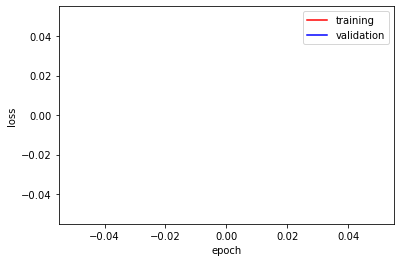

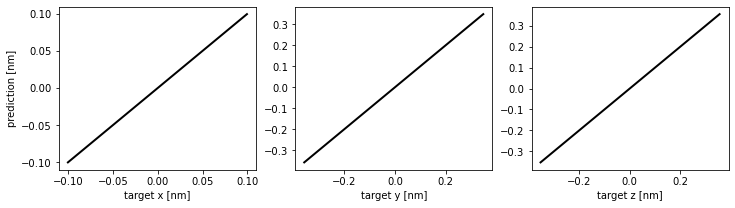

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [5]:
[tloader,vloader,txyzloader,vxyzloader]= \
    get_loaders('../generatingfeatures/longer_local_cai_aa_capm2opmnpmcpm.dat',0.8,\
                batch_size=512) 

m = Model1D3()
m.apply(m.initialize_weights)
m.zero_grad()

opt = torch.optim.Adam(m.parameters(), lr=0.001, weight_decay=0.000001)

epochs=30
showoutput=True

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,klfactor=2.0,xscale=10.0)

plot_progress(epochs,tloss,vloss)
plot_validation(vxyzloader,m)
linear_regression(vxyzloader,m)

torch.save(m.state_dict(),"ca_1d3_predict.dict")

We can continue with the training:

In [ ]:
epochs=10
[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,klfactor=2.0,xscale=10.0)

plot_progress(epochs,tloss,vloss)
plot_validation(vxyzloader,m)
linear_regression(vxyzloader,m)

torch.save(m.state_dict(),"ca_1d3_predict_2.dict")

and more training after loading the model again using a smaller learning rate.

The following code can be run after stopping and restarting the notebook because it starts from a saved set of weights.

In [ ]:
m=Model1D3()
m.load_state_dict(torch.load('ca_1d3_predict_2.dict'))

opt = torch.optim.Adam(m.parameters(), lr=0.0001, weight_decay=0.000001)

[tloader,vloader,txyzloader,vxyzloader]= \
    get_loaders('../generatingfeatures/longer_local_cai_aa_capm2opmnpmcpm.dat',0.8,\
                batch_size=512) 

showoutput=True
epochs=10

[tloss,vloss]=do_training(m,opt,txyzloader,vxyzloader,epochs,showoutput,klfactor=0.5,xscale=10.0)

plot_progress(epochs,tloss,vloss)
plot_validation(vxyzloader,m)
linear_regression(vxyzloader,m)

torch.save(m.state_dict(),"ca_1d3_predict_3.dict")